## Import Packages

In [20]:
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


## Read File

In [21]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]


## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [22]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [23]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'


## Data Classifier

In [24]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality


## Split dataset into x and y and one-hot encode quality column

In [25]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = OneHotEncoder().fit_transform(new_data[['quality']]).toarray()


## Train test split

In [26]:

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=10)


## Scale the data to Improve the speed of training Model

In [ ]:
!pip install matplotlib

range of the xTrain:
n_tokens_title                   2.000000e+01
n_tokens_content                 7.053000e+03
n_unique_tokens                  8.325642e-01
n_non_stop_words                 5.237800e-08
n_non_stop_unique_tokens         8.463732e-01
num_hrefs                        3.040000e+02
num_self_hrefs                   4.400000e+01
num_imgs                         1.000000e+02
num_videos                       6.500000e+01
average_token_length             4.416949e+00
num_keywords                     9.000000e+00
data_channel_is_lifestyle        1.000000e+00
data_channel_is_entertainment    1.000000e+00
data_channel_is_bus              1.000000e+00
data_channel_is_socmed           1.000000e+00
data_channel_is_tech             1.000000e+00
data_channel_is_world            1.000000e+00
kw_min_min                       3.190000e+02
kw_max_min                       1.022000e+05
kw_avg_min                       1.471786e+04
kw_min_max                       8.433000e+05
kw_max_max   

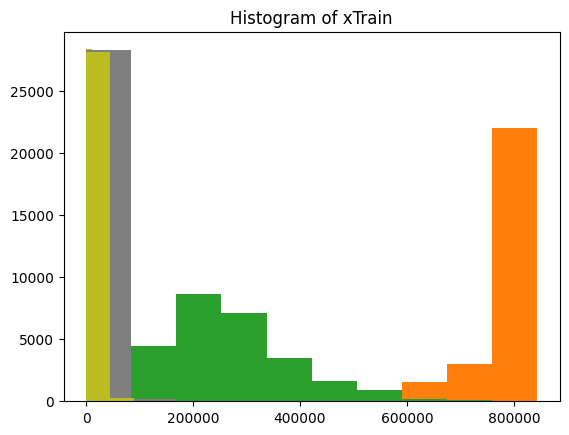

In [27]:

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


scaler = MinMaxScaler()
scale_xTrain = scaler.fit_transform(xTrain)
scale_xTest = scaler.fit_transform(xTest)

print("range of the xTrain:")
print(xTrain.max() - xTrain.min())
for i in xTrain.columns:
    plt.hist(xTrain[i])
plt.title("Histogram of xTrain")
plt.show()



## Create and train model(NN)

In [28]:
def build_nn_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mirror_strategy = tf.distribute.MirroredStrategy()
with mirror_strategy.scope():
    nn_model1 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])
    nn_model2 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])

    fit_speed = tf.data.Dataset.from_tensor_slices((scale_xTrain, yTrain))
    fit_speed = fit_speed.repeat().batch(100)

    nn_model1.fit(scale_xTrain, yTrain, epochs=10)
    nn_model2.fit(scale_xTrain, yTrain, epochs=10)

Epoch 1/10
892/892 [==============================] - 5s 4ms/step - loss: 1.2223 - accuracy: 0.4292
Epoch 2/10
892/892 [==============================] - 5s 5ms/step - loss: 1.2014 - accuracy: 0.4416
Epoch 3/10
892/892 [==============================] - 4s 4ms/step - loss: 1.1927 - accuracy: 0.4455
Epoch 4/10
892/892 [==============================] - 4s 4ms/step - loss: 1.1879 - accuracy: 0.4466
Epoch 5/10
892/892 [==============================] - 5s 5ms/step - loss: 1.1820 - accuracy: 0.4509
Epoch 6/10
892/892 [==============================] - 4s 4ms/step - loss: 1.1791 - accuracy: 0.4530
Epoch 7/10
892/892 [==============================] - 4s 4ms/step - loss: 1.1750 - accuracy: 0.4547
Epoch 8/10
892/892 [==============================] - 6s 6ms/step - loss: 1.1712 - accuracy: 0.4554
Epoch 9/10
892/892 [==============================] - 5s 5ms/step - loss: 1.1670 - accuracy: 0.4590
Epoch 10/10
892/892 [==============================] - 4s 4ms/step - loss: 1.1628 - accuracy: 0.4605

## Create and train model(Random Forest)

In [29]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(scale_xTrain, yTrain.argmax(axis=1))


RandomForestClassifier()

## Make predictions with each model individually

In [30]:
nn1_train_pred = nn_model1.predict(scale_xTrain)
nn2_train_pred = nn_model2.predict(scale_xTrain)
RF_train_pred = RF_model.predict_proba(scale_xTrain)

nn1_test_pred = nn_model1.predict(scale_xTest)
nn2_test_pred = nn_model2.predict(scale_xTest)
RF_test_pred = RF_model.predict_proba(scale_xTest)

print("Shape:")
print("nn1_train_pred:", nn1_train_pred.shape)
print("nn2_train_pred:", nn2_train_pred.shape)
print("RF_train_pred:", RF_train_pred.shape)

nn1_train_labels = nn1_train_pred.argmax(axis=1)
nn2_train_labels = nn2_train_pred.argmax(axis=1)
RF_train_labels = RF_train_pred.argmax(axis=1)

nn1_test_labels = nn1_test_pred.argmax(axis=1)
nn2_test_labels = nn2_test_pred.argmax(axis=1)
RF_test_labels = RF_test_pred.argmax(axis=1)

print("Labels:")
print("nn1_train_pred:", nn1_train_labels)
print("nn2_train_pred:", nn2_train_labels)
print("RF_train_pred:", RF_train_labels)
print("nn1_test_pred:", nn1_test_labels)
print("nn2_test_pred:", nn2_test_labels)
print("RF_test_pred:", RF_test_labels)
print()

223/223 [==============================] - 1s 3ms/step
Shape:
nn1_train_pred: (28543, 4)
nn2_train_pred: (28543, 4)
RF_train_pred: (28543, 4)
Labels:
nn1_train_pred: [1 0 3 ... 0 3 3]
nn2_train_pred: [3 0 3 ... 3 3 3]
RF_train_pred: [0 3 3 ... 0 3 0]
nn1_test_pred: [3 1 3 ... 3 3 1]
nn2_test_pred: [3 1 3 ... 3 3 1]
RF_test_pred: [3 1 3 ... 3 3 1]



## Simple Ensemble: 3 linear models

## Train the 3 linear models

In [31]:
from sklearn.linear_model import LinearRegression
linmodel_1 = LinearRegression()
linmodel_2 = LinearRegression()
linmodel_3 = LinearRegression()

linmodel_1.fit(scale_xTrain,yTrain)
linmodel_2.fit(scale_xTrain,yTrain)
linmodel_3.fit(scale_xTrain,yTrain)

LinearRegression()

## Get the predictions out of the 3 linear regression models

In [32]:
linmodel1_train_pred = linmodel_1.predict(scale_xTrain)
linmodel2_train_pred = linmodel_2.predict(scale_xTrain)
linmodel3_train_pred = linmodel_3.predict(scale_xTrain)

linmodel1_test_pred = linmodel_1.predict(scale_xTest)
linmodel2_test_pred = linmodel_2.predict(scale_xTest)
linmodel3_test_pred = linmodel_3.predict(scale_xTest)

## Get the ensemble prediction

In [33]:
ensemble_simple_train_pred = (linmodel1_train_pred + linmodel2_train_pred + linmodel3_train_pred) / 3
ensemble_simple_test_pred = (linmodel1_test_pred + linmodel2_test_pred + linmodel3_test_pred) / 3

ensemble_simple_train_labels = ensemble_simple_train_pred.argmax(axis=1)
ensemble_simple_test_labels = ensemble_simple_test_pred.argmax(axis=1)

## (Simple Ensemble) Classification Report

In [34]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_simple_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_simple_test_labels))

print("Training error")

Train:
              precision    recall  f1-score   support

           0       0.47      0.49      0.48      8336
           1       0.37      0.07      0.12      5734
           2       0.36      0.03      0.06      2887
           3       0.44      0.71      0.54     11586

    accuracy                           0.45     28543
   macro avg       0.41      0.33      0.30     28543
weighted avg       0.43      0.45      0.39     28543

Test:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2095
           1       0.13      0.11      0.12      1406
           2       0.11      0.89      0.19       729
           3       0.00      0.00      0.00      2906

    accuracy                           0.11      7136
   macro avg       0.06      0.25      0.08      7136
weighted avg       0.04      0.11      0.04      7136

Training error


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Medium Complex Ensemble: 2 NN + 1 Linear

In [37]:
ensemble_medium_train_pred = (nn1_train_pred + nn2_train_pred + linmodel1_train_pred) / 3
ensemble_medium_test_pred = (nn1_test_pred + nn2_test_pred + linmodel1_test_pred) / 3

ensemble_train_labels = ensemble_medium_train_pred.argmax(axis=1)
ensemble_test_labels = ensemble_medium_test_pred.argmax(axis=1)

In [38]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_test_labels))

Train:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48      8336
           1       0.45      0.14      0.22      5734
           2       0.41      0.02      0.04      2887
           3       0.45      0.75      0.56     11586

    accuracy                           0.47     28543
   macro avg       0.46      0.34      0.32     28543
weighted avg       0.47      0.47      0.42     28543

Test:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2095
           1       0.13      0.11      0.12      1406
           2       0.11      0.89      0.19       729
           3       0.00      0.00      0.00      2906

    accuracy                           0.11      7136
   macro avg       0.06      0.25      0.08      7136
weighted avg       0.04      0.11      0.04      7136



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Complex Ensemble: 2 NN + 1 RF

In [35]:
ensemble_train_pred = (nn1_train_pred + nn2_train_pred + RF_train_pred) / 3
ensemble_test_pred = (nn1_test_pred + nn2_test_pred + RF_test_pred) / 3

ensemble_train_labels = ensemble_train_pred.argmax(axis=1)
ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

print("ensemble_train_labels:",ensemble_train_labels)
print("ensemble_train_labels:",ensemble_train_labels)


ensemble_train_labels: [0 3 3 ... 0 3 3]
ensemble_train_labels: [0 3 3 ... 0 3 3]


## Model Evaluation

In [36]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_test_labels))


Train:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      8336
           1       0.93      0.69      0.80      5734
           2       1.00      0.45      0.62      2887
           3       0.77      0.98      0.86     11586

    accuracy                           0.84     28543
   macro avg       0.90      0.75      0.79     28543
weighted avg       0.86      0.84      0.83     28543

Test:
              precision    recall  f1-score   support

           0       0.58      0.27      0.36      2095
           1       0.39      0.23      0.28      1406
           2       0.34      0.03      0.06       729
           3       0.44      0.80      0.57      2906

    accuracy                           0.45      7136
   macro avg       0.44      0.33      0.32      7136
weighted avg       0.46      0.45      0.40      7136



In [ ]:
from sklearn.metrics import accuracy_score
nn1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn1_train_labels)
nn2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn2_train_labels)
RF_train_accuracy = accuracy_score(yTrain.argmax(axis=1), RF_train_labels)

nn1_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn1_test_labels)
nn2_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn2_test_labels)
RF_test_accuracy = accuracy_score(yTest.argmax(axis=1), RF_test_labels)

ensemble_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
ensemble_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)

print("Model Train Accuracies:")
print(f"Neural Network 1: {nn1_train_accuracy:.4f}")
print(f"Neural Network 2: {nn2_train_accuracy:.4f}")
print(f"Random Forest: {RF_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"Neural Network 1: {nn1_test_accuracy:.4f}")
print(f"Neural Network 2: {nn2_test_accuracy:.4f}")
print(f"Random Forest: {RF_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_test_accuracy:.4f}")

Model Train Accuracies:
Neural Network 1: 0.4598
Neural Network 2: 0.4655
Random Forest: 1.0000

Model Test Accuracies:
Neural Network 1: 0.4301
Neural Network 2: 0.4409
Random Forest: 0.4261

Ensemble Model:
Training Accuracy: 0.8786
Testing Accuracy: 0.4410
